In [2]:
import xarray as xr
import numpy as np
import glob
import typhon
import matplotlib.pyplot as plt
from os.path import join
plt.style.use(typhon.plots.styles.get('typhon')) 

In [3]:
data_dir = "/work/mh0287/m300057/NextGEMS/"
runs = ["dpp0029", "dpp0033", "dpp0016", "dpp0052", "dpp0001"]

In [4]:
# constants:
alv = 2.5008e6
als = 2.8345e6

# pr: everything (liquid parts + solid parts)
# prls: solid parts

# [alv] = J/kg
# [pr] = kg/m^2/s
# [alv * pr] = J/m^2/s

# [dse] = m^2/s^2 = J/kg
# [prw] = kg/m^2
# [alv * prw] = J/m^2

Energy budget:
-rlut + rlus - rlds + rsdt - rsut - rsds + rsus - hfss + alv pr + (als-alv) prls

In [5]:
ds = {}
for run in runs:
    file = join(data_dir, f'{run}_atm_2d_ml_daymean_fldmean.nc')
    ds[run] = xr.open_dataset(file)

In [6]:
ahb_ifs_feb = 8.0071
ahb_ifs_mar = 6.7942
ahb_ifs_feb_mar = np.mean([ahb_ifs_feb, ahb_ifs_mar])
ahb_ifs_deepcon_feb_mar = 4.1776

In [7]:
ds["dpp0001"]['time'] = ds["dpp0001"]['time'] + np.timedelta64(365*4, 'D')

In [8]:
for run in runs:
    ds[run]["e_budget"] = -ds[run].rlut + ds[run].rlus - ds[run].rlds\
    + ds[run].rsdt - ds[run].rsut - ds[run].rsds + ds[run].rsus\
    - ds[run].hfss + alv*ds[run].pr + (als-alv)*ds[run].prls
    
    ds[run]["net_radiation"] = -ds[run].rlut + ds[run].rlus - ds[run].rlds + ds[run].rsdt - ds[run].rsut - ds[run].rsds + ds[run].rsus
    
    ds[run]["heat"] = -ds[run].hfss + alv*ds[run].pr + (als-alv)*ds[run].prls

ds["dpp0052"]["dse"] = ds["dpp0052"].cptgzvi
ds["dpp0052"]["mse"] = ds["dpp0052"].cptgzvi + ds["dpp0052"].prw * alv

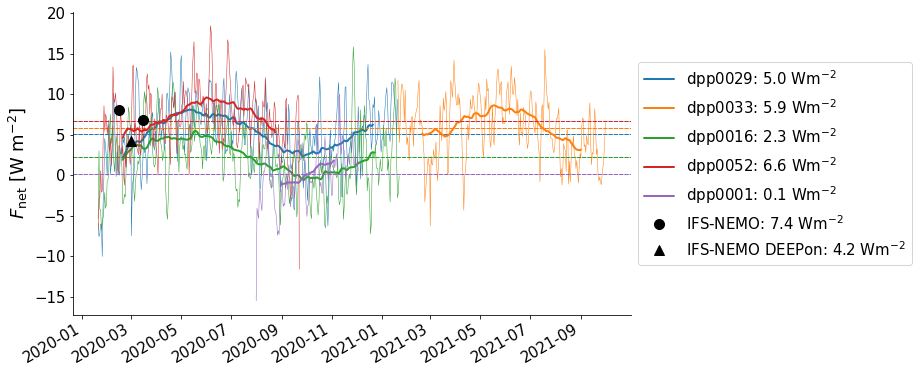

In [100]:
def running_mean(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

n = 30
colors=[f'C{i}' for i in range(6)]
fig, ax = plt.subplots()
for i, run in enumerate(runs):
    mean_e_b = np.squeeze(ds[run].e_budget.mean(dim='time'))
    ax.plot(ds[run].time, np.squeeze(ds[run].e_budget), lw=0.5, color=colors[i])
    ax.plot(ds[run].time[n:-n], running_mean(np.squeeze(ds[run].e_budget.values),n=(n*2 +1)), color=colors[i], linewidth=2, label=f'{run}: {mean_e_b.data:.1f} '+'Wm$^{-2}$')
    ax.axhline(mean_e_b, color=colors[i], lw=1, ls='--')
    
ax.plot(np.datetime64("2020-02-15T00:00:00.000000000"), ahb_ifs_feb, 'o', color='k')
ax.plot(np.datetime64("2020-03-15T00:00:00.000000000"), ahb_ifs_mar, 'o', color='k', label=f'IFS-NEMO: {ahb_ifs_feb_mar:.1f} '+'Wm$^{-2}$')
ax.plot(np.datetime64("2020-03-01T00:00:00.000000000"), ahb_ifs_deepcon_feb_mar, '^', color='k', label=f'IFS-NEMO DEEPon: {ahb_ifs_deepcon_feb_mar:.1f} '+'Wm$^{-2}$')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.gcf().autofmt_xdate()
ax.set_ylabel(r'$F_\mathrm{net}$ [W m$^{-2}$]')
plt.savefig('Plots/energy_budget.pdf')
plt.savefig('Plots/energy_budget.png', dpi=400, bbox_inches='tight')

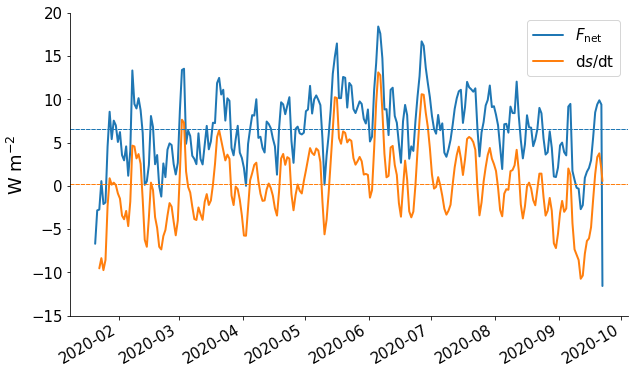

In [13]:
fig, ax = plt.subplots()
for run in ["dpp0052"]:
    ax.plot(ds[run].time, np.squeeze(ds[run].e_budget), color='C0', label='$F_\mathrm{net}$')
    d_dse = np.gradient(np.squeeze(ds[run].dse))/(24*60*60)
    ax.plot(ds[run].time[2:], d_dse[2:], color='C1', label='d$s$/dt')
    ax.axhline(np.mean(np.squeeze(ds[run].e_budget)), color='C0', ls='--', lw=1)
    ax.axhline(np.mean(d_dse[2:]), color='C1', ls='--', lw=1)
    
    
ax.legend()
plt.gcf().autofmt_xdate()
ax.set_ylabel('W m$^{-2}$')
ax.set_ylim(-15, 20)

plt.savefig('Plots/energy_budget_dse.pdf')
plt.savefig('Plots/energy_budget_dse.png', dpi=400)

3 meters of water warm by two degrees over 8 months
--> that corresponds to about 0.5 W m-2 energy input 

In [10]:
np.mean(ds['dpp0052'].e_budget)

<xarray.DataArray 'e_budget' ()>
array(6.632828, dtype=float32)

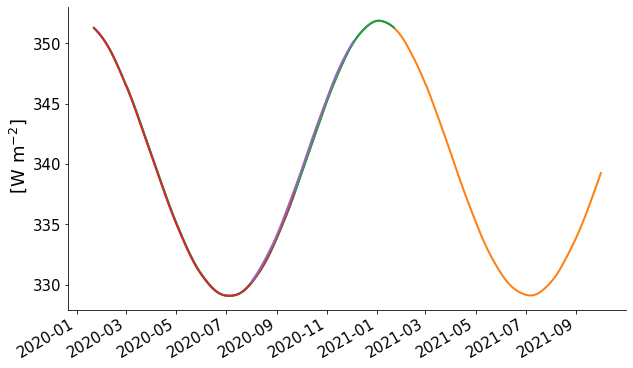

In [112]:
fig, ax = plt.subplots()
for run in runs:
    ax.plot(ds[run].time[1:], np.squeeze(ds[run].rsdt[1:]))
ax.set_ylabel(' [W m$^{-2}$]')
plt.gcf().autofmt_xdate()